# CS 542 Fall 2025 Project 1

Your task for this project to train a better model for the Tree-or-Not data set.
Your model will be constrained to use the architecture in this template.
To train a better model, you will instead practice picking appropriate initializations and regularizations.



## Background

This notebook builds a model detecting trees in images.
The data set is available on GitHub at https://github.com/DL4DS/tree-or-not or on the Shared Compute Cluster at `/projectnb/ds542/materials/tree-or-not`.
The initial data set consists of roughly 500 pictures.
Most of them are from the Boston area, but some are from around the globe.
Most of them were taken outside, but some were taken inside or in more exotic locations.
Many other factors such as lighting, weather, and confounding bushes will make this a challenging problem.

## Outline

1. Run the provided notebook and confirm basic functionality.
2. Pick, describe and demonstrate a training improvement in each of the following categories - early stopping, initialization, learning rate, and other regularization. (40%)
3. Train models with all 16 combinations of the previous 4 choices and plot their training progress. (10%)
4. In one week (10/13), a new validation set will be posted. Show the accuracy of your 16 models on this new validation data.
6. Explain as best you can why each improvement was included or not included in the best performing model. (20%)
5. Save the best performing model for further evaluation by the auto-grader. (30%)


## Modules

In [1]:
# automatically add location of class packages if running on the SCC

import os
import sys

scc_site_packages = "/projectnb/ds542/materials/lib/python3.12/site-packages"
if os.path.isdir(scc_site_packages) and scc_site_packages not in sys.path:
    sys.path.append(scc_site_packages)


In [2]:
import imageio.v2 as imageio
import livelossplot
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torcheval.metrics

## GPU Access

In [3]:
def to_gpu(t):
    if torch.cuda.is_available():
        return t.cuda()
    return t

def to_numpy(t):
    return t.detach().cpu().numpy()

device = to_gpu(torch.ones(1,1)).device
device

device(type='cuda', index=0)

## Load Data

If you are not running on the SCC, fetch the data from https://github.com/dl4ds/tree-or-not as needed.
For example, you could use `git clone` to make a local copy and update `data_dir` below.

In [4]:
image_width = 256 # DO NOT CHANGE
data_dir = "/projectnb/ds542/materials/tree-or-not"

def load_data_set(data_set_name):
    labels = pd.read_csv(f"{data_dir}/{data_set_name}.tsv", sep="\t")

    file_names = []
    images = []
    targets = []
    for i in range(labels.shape[0]):
        row = labels.iloc[i]
        try:
            image = imageio.imread(f"{data_dir}/images{image_width}/{row['filename']}")[...]
        except:
            print("SKIPPING ", row['filename'], "MISSING")
            continue

        if image.shape[0] != image.shape[1] * 3 // 4:
            print("SKIPPING ", row['filename'], image.shape)
            continue

        # convert from 0-255 to 0.0-1.0
        image = image / 255
        # prepend axis with length one
        # image = image.reshape(1, *image.shape)
        image = torch.tensor(image, device=device, dtype=torch.float32)
        # permute image dimensions to put color channel first
        image = torch.permute(image, [2, 0, 1])

        file_names.append(row['filename'])
        images.append(image)
        targets.append(row["target"])

    images = torch.stack(images)

    targets = torch.tensor(targets, device=device, dtype=torch.float32)
    targets = targets.long()

    return (file_names, images, targets)

train_data_set = load_data_set("train")
for t in train_data_set[1:]:
    print("TRAIN", t.shape, t.dtype, t.device)
(train_file_names, train_X, train_Y) = train_data_set

validation_data_set = load_data_set("validation")
for t in validation_data_set[1:]:
    print("VALIDATION", t.shape, t.dtype, t.device)
(validation_file_names, validation_X, validation_Y) = validation_data_set

TRAIN torch.Size([292, 3, 192, 256]) torch.float32 cuda:0
TRAIN torch.Size([292]) torch.int64 cuda:0
VALIDATION torch.Size([97, 3, 192, 256]) torch.float32 cuda:0
VALIDATION torch.Size([97]) torch.int64 cuda:0


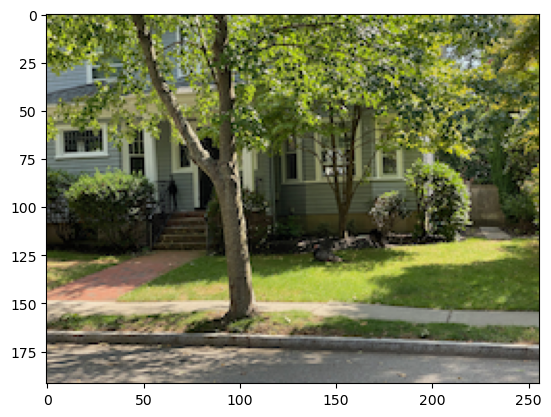

In [5]:
plt.imshow(to_numpy(torch.permute(train_X[0,:,:,:], (1, 2, 0))));

## Model Building

Do not modify any of this code.

In [6]:
class TreeNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_0 = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, device=device)
        self.conv_1 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, stride=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, stride=2, device=device)
        self.conv_3 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, stride=2, device=device)
        self.fc_3 = torch.nn.Linear(585, 2)

        self.relu = torch.nn.ReLU()

    def forward(self, X):

        X = self.conv_0(X)
        X = self.relu(X)

        X = self.conv_1(X)
        X = self.relu(X)

        X = self.conv_2(X)
        X = self.relu(X)

        X = self.conv_3(X)
        X = self.relu(X)

        # flatten channels and image dimensions
        X = X.reshape(X.shape[:-3] + (-1,))

        X = self.fc_3(X)

        return X

test_model = TreeNetwork().to(device)
test_output = test_model(train_X[:5,:,:,:])
assert test_output.shape == (5, 2)
del test_output

In [7]:
loss_function = torch.nn.CrossEntropyLoss()

In [8]:
DEFAULT_EPOCHS = 1000 if torch.cuda.is_available() else 100

def train_model(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, **kwargs):
    model = model_class(**kwargs)
    if torch.cuda.is_available():
        model = model.cuda()

    model = torch.nn.DataParallel(model)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    liveloss = livelossplot.PlotLosses()
    for i in range(epochs):
        model.train()

        optimizer.zero_grad(set_to_none=True)
        prediction = model(train_X)
        loss = loss_function(prediction, train_Y)
        loss.backward()
        optimizer.step()

        if (i + 1) % 50 == 0:
            liveloss_updates = {}
            with torch.no_grad():
                model.eval()

                def get_metrics(metrics_prefix, metrics_X, metrics_Y):
                    metrics_prediction = model(metrics_X)

                    return {
                        f"{metrics_prefix}loss": loss_function(metrics_prediction, metrics_Y),
                        f"{metrics_prefix}accuracy": torcheval.metrics.functional.multiclass_accuracy(torch.argmax(metrics_prediction, dim=-1), metrics_Y)
                    }

                liveloss_updates.update(get_metrics("", train_X, train_Y))
                liveloss_updates.update(get_metrics("val_", validation_X, validation_Y))

            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

    return model

test_model = train_model(TreeNetwork, epochs=1)
del test_model

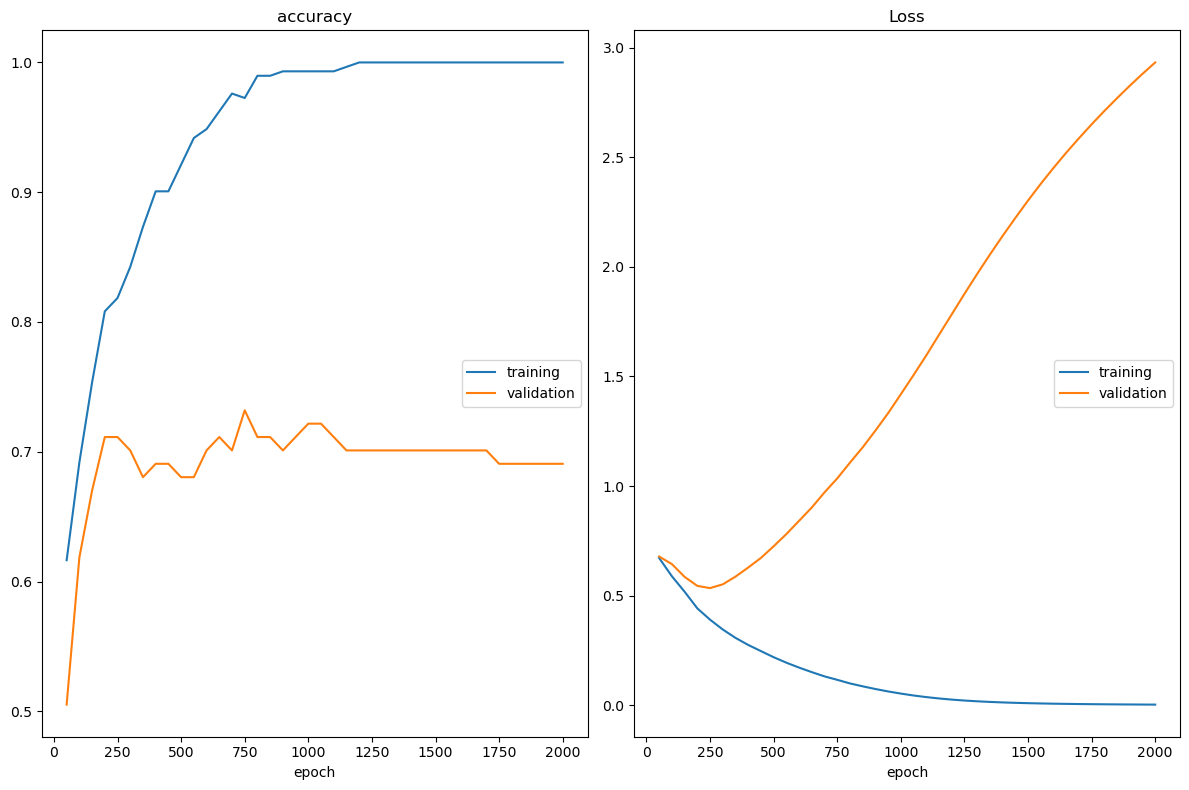

accuracy
	training         	 (min:    0.616, max:    1.000, cur:    1.000)
	validation       	 (min:    0.505, max:    0.732, cur:    0.691)
Loss
	training         	 (min:    0.003, max:    0.672, cur:    0.003)
	validation       	 (min:    0.534, max:    2.933, cur:    2.933)


In [9]:
base_model = train_model(TreeNetwork, epochs=2000)

## Training Improvements

Pick and describe training improvements in each of the following categories.
**Your description must be specific to this data set and baseline training process.**
You do not need to describe how these methods work in general, and generalities may cost points for making your answer less concise.

Warning:
Your training improvements will be sanity checked when models are built with them below.
If your training improvement does not improve the validation accuracy, then it will deemed inappropriate for this specific data set and architecture, and you will lose points here.

### Early Stopping

The baseline model overfits a lot.
Make a chart illustrating the overfitting problem in the base model and indicate roughly where the model should have stopped training.

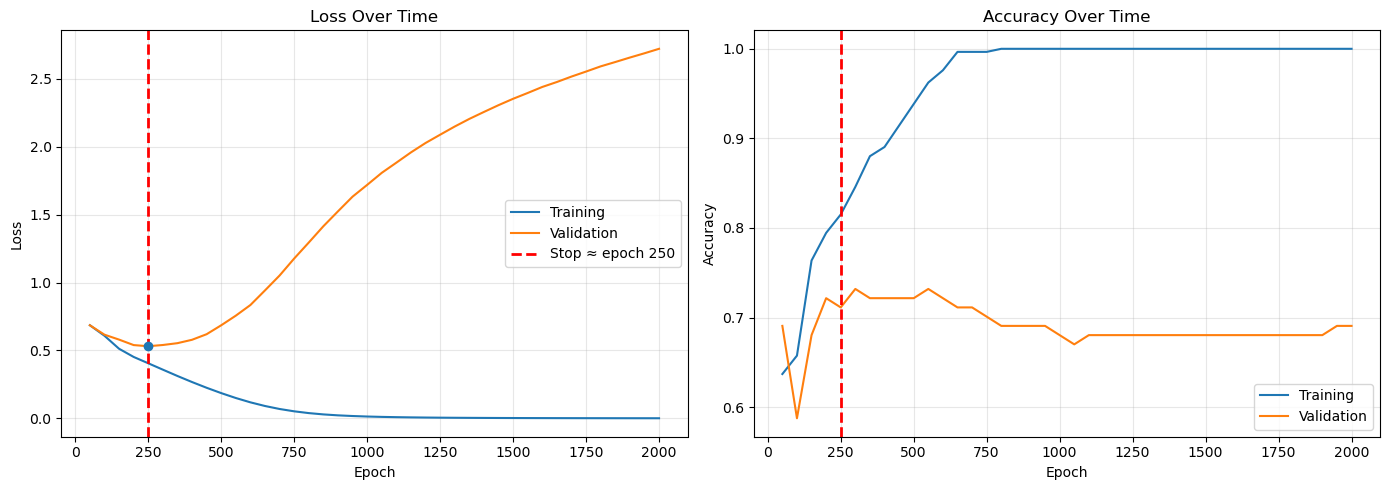

Early-stop ≈ epoch 250 | min val loss = 0.5314 | val acc at stop = 0.7113


In [11]:
import numpy as np
LOG_EVERY = 50  
def train_model_with_history(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, **kwargs):
    model = model_class(**kwargs)
    if torch.cuda.is_available():
        model = model.cuda()
    model = torch.nn.DataParallel(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    history = {"epochs": [], "train_loss": [], "train_accuracy": [],
               "val_loss": [], "val_accuracy": []}

    for i in range(epochs):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        pred = model(train_X)
        loss = loss_function(pred, train_Y)
        loss.backward()
        optimizer.step()

        if (i + 1) % LOG_EVERY == 0:
            with torch.no_grad():
                model.eval()
                tr_pred = model(train_X)
                va_pred = model(validation_X)
                tr_loss = loss_function(tr_pred, train_Y).item()
                va_loss = loss_function(va_pred, validation_Y).item()
                tr_acc = torcheval.metrics.functional.multiclass_accuracy(
                    tr_pred.argmax(-1), train_Y).item()
                va_acc = torcheval.metrics.functional.multiclass_accuracy(
                    va_pred.argmax(-1), validation_Y).item()

            history["epochs"].append(i + 1)
            history["train_loss"].append(tr_loss)
            history["val_loss"].append(va_loss)
            history["train_accuracy"].append(tr_acc)
            history["val_accuracy"].append(va_acc)

    return model, history

base_model, history = train_model_with_history(TreeNetwork, epochs=2000, learning_rate=1e-4)

epochs = np.array(history["epochs"])
val_losses = np.array(history["val_loss"])
train_losses = np.array(history["train_loss"])
val_accs = np.array(history["val_accuracy"])
train_accs = np.array(history["train_accuracy"])

best_idx = int(np.argmin(val_losses))
best_epoch = int(epochs[best_idx])
best_val = float(val_losses[best_idx])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, train_losses, label="Training")
ax1.plot(epochs, val_losses, label="Validation")
ax1.axvline(best_epoch, color="red", linestyle="--", linewidth=2, label=f"Stop ≈ epoch {best_epoch}")
ax1.scatter([best_epoch], [best_val], zorder=3)
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.set_title("Loss Over Time"); ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(epochs, train_accs, label="Training")
ax2.plot(epochs, val_accs, label="Validation")
ax2.axvline(best_epoch, color="red", linestyle="--", linewidth=2)
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy"); ax2.set_title("Accuracy Over Time"); ax2.legend(); ax2.grid(alpha=0.3)

plt.tight_layout(); plt.show()
print(f"Early-stop ≈ epoch {best_epoch} | min val loss = {best_val:.4f} | val acc at stop = {val_accs[best_idx]:.4f}")

Describe how you will detect overfitting to trigger early stopping.
Specific details might include how your detection code avoids triggering on noise.
(This might require a finer-grained validation loss chart.)

The red line in the chart above indicate roughly where the model should stop before it getting overfitting. 
We detect overfitting by tracking the validation loss each epoch, denoised via a rolling median (k=7). After a warm-up of 100 epochs, we require a minimum decrease of 0.001 to count as improvement. If the smoothed validation loss fails to improve for 150 consecutive epochs, we stop and restore the checkpoint with the lowest smoothed validation loss. This avoids stopping on noisy fluctuations and prevents selecting a checkpoint that is overly tuned to the validation split while still giving the learning-rate scheduler time to act. The chart below give a closer look on how noisy it is. 

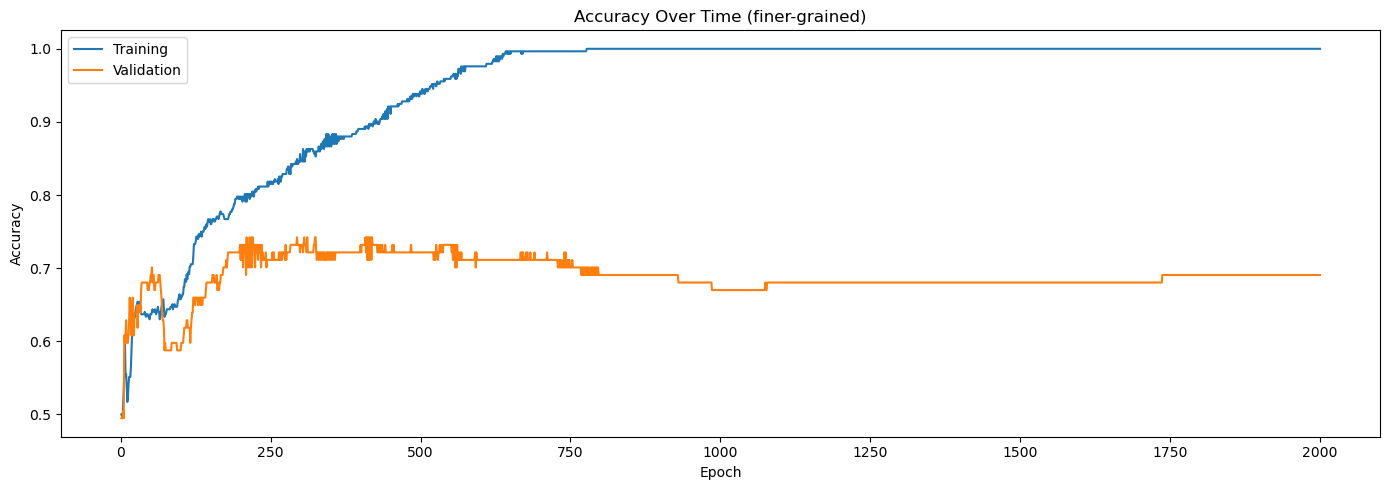

In [14]:
LOG_EVERY = 1

base_model, history = train_model_with_history(TreeNetwork, epochs=2000, learning_rate=1e-4)

epochs = np.array(history["epochs"])
val_losses = np.array(history["val_loss"])
train_losses = np.array(history["train_loss"])
val_accs = np.array(history["val_accuracy"])
train_accs = np.array(history["train_accuracy"])

best_idx = int(np.argmin(val_losses))
best_epoch = int(epochs[best_idx])
best_val = float(val_losses[best_idx])

plt.figure(figsize=(14,5))
plt.plot(epochs, train_accs, label="Training")
plt.plot(epochs, val_accs, label="Validation")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Over Time (finer-grained)"); plt.legend()

plt.tight_layout(); plt.show()

### Initialization

Pick a better initialization method for this neural network.
What does this initialization method do better than the baseline code?

As plots shown below, with Xavier, validation loss stays much lower and training is noticeably more stable—the baseline’s loss climbs and eventually blows up after ~600–800 epochs, a clear sign of overfitting. However, the baseline achieves a higher peak validation accuracy (≈0.78–0.80) before it drifts, while Xavier-all peaks lower (≈0.72–0.73). While it has lower accuracy in validation, it shows a stability, we could combine it with early stopping policy to prevent. Overall, Xavier reaches a lower loss and avoids late-epoch instability.

Give an illustrate how your initialization method does better.
This might be a chart or some numerical representation of the difference.

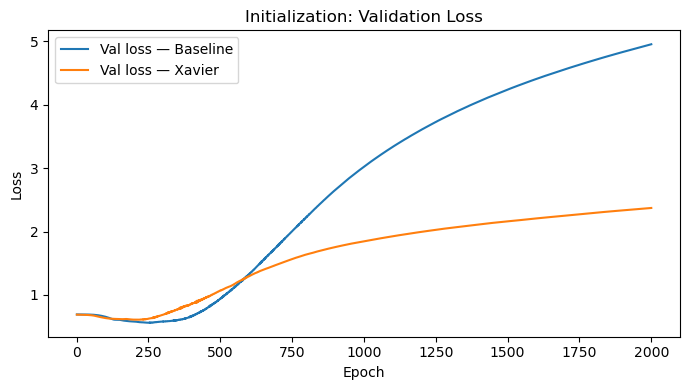

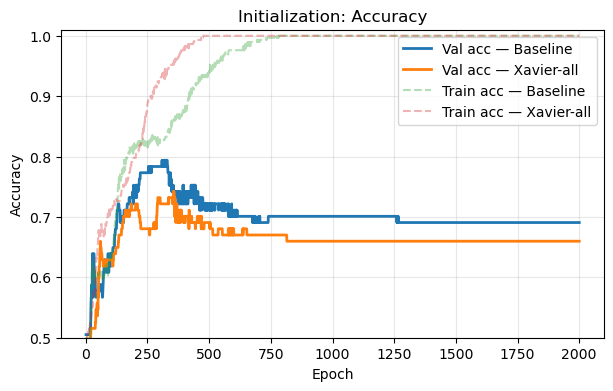

In [13]:
# YOUR ANSWER HERE
import numpy as np
import torch.nn as nn
torch.manual_seed(55)
DEMO_EPOCHS = 2000
LR = 1e-4

def demo_model():
    m = TreeNetwork()
    if torch.cuda.is_available(): m = m.cuda()
    return torch.nn.DataParallel(m)

def apply_xavier_all(model):
    core = model.module if hasattr(model, "module") else model
    for m in core.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)  # ← Use Xavier
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def train_collect(model, epochs=DEMO_EPOCHS, lr=LR):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    trL, vaL, trA, vaA = [], [], [], []
    for _ in range(epochs):
        model.train(); opt.zero_grad(set_to_none=True)
        loss = loss_function(model(train_X), train_Y); loss.backward(); opt.step()

        model.eval()
        with torch.no_grad():
            tl = float(loss_function(model(train_X), train_Y))
            vl = float(loss_function(model(validation_X), validation_Y))
            ta = (model(train_X).argmax(-1) == train_Y).float().mean().item()
            va = (model(validation_X).argmax(-1) == validation_Y).float().mean().item()
        trL.append(tl); vaL.append(vl); trA.append(ta); vaA.append(va)
    return np.array(trL), np.array(vaL), np.array(trA), np.array(vaA)

# --- Baseline init
m_base = demo_model()
tr_b, va_b, ta_b, vaa_b = train_collect(m_base)

m_k = demo_model()
apply_xavier_all(m_k)
tr_k, va_k, ta_k, vaa_k = train_collect(m_k)

# --- Plots
epochs = np.arange(1, DEMO_EPOCHS+1)

plt.figure(figsize=(7,4))
plt.plot(epochs, va_b, label="Val loss — Baseline")
plt.plot(epochs, va_k, label="Val loss — Xavier")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Initialization: Validation Loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(epochs, vaa_b, label="Val acc — Baseline", linewidth=2)
plt.plot(epochs, vaa_k, label="Val acc — Xavier-all", linewidth=2)
plt.plot(epochs, ta_b, alpha=0.35, linestyle="--", label="Train acc — Baseline")
plt.plot(epochs, ta_k, alpha=0.35, linestyle="--", label="Train acc — Xavier-all")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Initialization: Accuracy"); plt.ylim([0.5, 1.01]); plt.legend(); plt.grid(alpha=0.3)


### Learning Rate

The ADAM optimizer is often touted as needing no hyperparameter tuning except for the learning rate.
What is the best improvement that you achieved just changing the learning rate?
What was your best learning and was it a material change?


The plot shows that a fixed learning rate of 1e-4 quickly overfits this dataset: after an early dip, the validation loss steadily climbs and reaches ~5.0 loss at epoch 2000. In contrast, the ReduceLROnPlateau scheduler tracks the validation loss and automatically reduces the LR when progress stalls. Each drop in LR flattens the curve and prevents the runaway increase, keeping the validation loss in a much lower band. The result show that with scheduler, the loss is 5 times lower than the base learning rate and it would make the model perform better. 

Make a chart showing the improvements (or lack thereof) from optimizing just the learning rate.

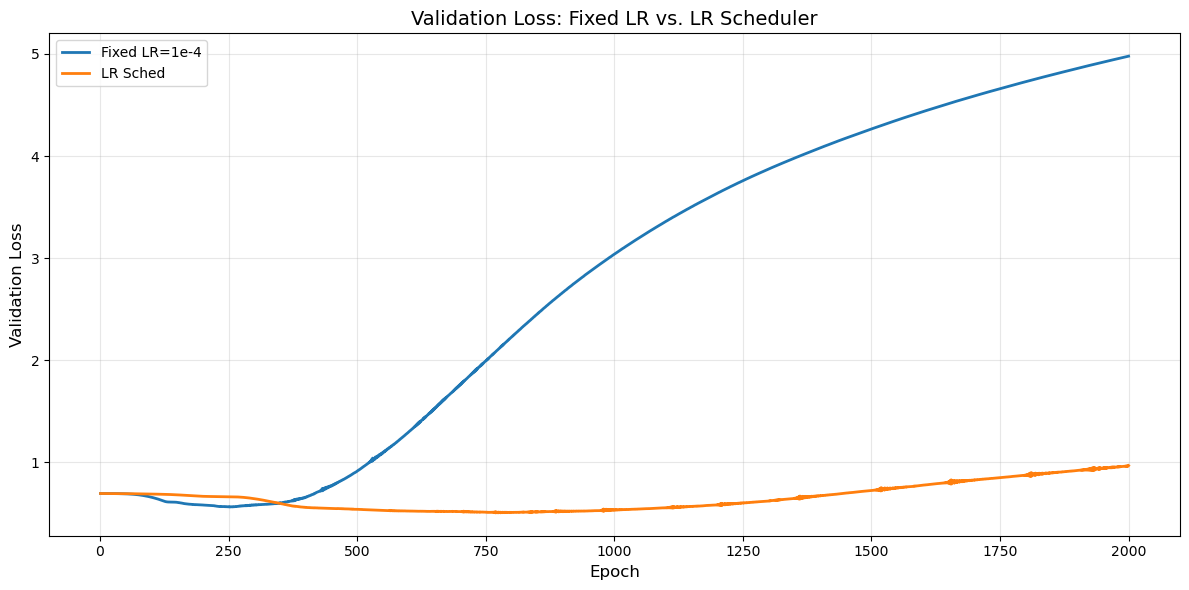

In [18]:
# YOUR ANSWER HERE
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(55)

def train_eval(model, optimizer, epochs=2000):
    train_losses, val_losses = [], []
    crit = loss_function
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad(set_to_none=True)
        logits = model(train_X)
        loss = crit(logits, train_Y)
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            tl = float(crit(model(train_X), train_Y))
            vl = float(crit(model(validation_X), validation_Y))
        train_losses.append(tl); val_losses.append(vl)
    return train_losses, val_losses

def train_eval_with_scheduler(model, optimizer, scheduler, epochs=2000):
    crit = loss_function
    tr_losses, va_losses, lr_hist = [], [], []
    for _ in range(epochs):
        model.train(); optimizer.zero_grad(set_to_none=True)
        logits = model(train_X); loss = crit(logits, train_Y)
        loss.backward(); optimizer.step()

        model.eval()
        with torch.no_grad():
            tr_losses.append(float(crit(model(train_X), train_Y)))
            v = float(crit(model(validation_X), validation_Y))
            va_losses.append(v)

        scheduler.step(v) 
        lr_hist.append(optimizer.param_groups[0]['lr'])
    return tr_losses, va_losses, lr_hist

def fresh_model():
    m = TreeNetwork()
    if torch.cuda.is_available(): m = m.cuda()
    return torch.nn.DataParallel(m)
    
EPOCHS = 2000
BASE_LR = 1e-4

m_fixed = fresh_model()
opt_fixed = torch.optim.Adam(m_fixed.parameters(), lr=BASE_LR)
tr_fixed, va_fixed = train_eval(m_fixed, opt_fixed, epochs=EPOCHS)
lr_fixed_hist = [BASE_LR] * EPOCHS


m_rlp_g = fresh_model()
opt_rlp_g = torch.optim.Adam(m_rlp_g.parameters(), lr=BASE_LR)
sch_rlp_g = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt_rlp_g, mode='min', factor=0.7, patience=12, threshold=1e-3,
    threshold_mode='rel', min_lr=5e-5
)
tr_rlp, va_rlp, lr_rlp_hist = train_eval_with_scheduler(m_rlp_g, opt_rlp_g, sch_rlp_g, epochs=EPOCHS)

epochs = np.arange(1, EPOCHS+1)

plt.figure(figsize=(12,6))
plt.plot(epochs, va_fixed,   label="Fixed LR=1e-4", linewidth=2)
plt.plot(epochs, va_rlp,   label="LR Sched", linewidth=2)
plt.title("Validation Loss: Fixed LR vs. LR Scheduler", fontsize=14)
plt.xlabel("Epoch", fontsize=12); plt.ylabel("Validation Loss", fontsize=12)
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()


### Regularization

Pick an appropriate regularization method that we covered in class besides early stopping and learning rate.
Explain why you picked this particular method for this problem and model.

YOUR ANSWER HERE

I choose dropout method to improve the model. Dropout clearly reduces overfitting and gives us a better generalization window than the baseline. In the baseline plots, training accuracy rockets to ~100% while validation accuracy plateaus near ≈0.70 and then drifts down; the validation loss explodes from ~0.6 to ≈3.0 by 2k epochs. With dropout (as shown below), training improves more slowly but validation accuracy climbs to about ≈0.72–0.74 and stays steadier; meanwhile the validation loss rises much more slowly, ending around ≈1.0 instead of 3.0. In other words, dropout lowers the train–val gap, delays the late-epoch divergence, and slightly improves the best validation accuracy. 

In [31]:
class TreeNetDropHead(torch.nn.Module):
    def __init__(self, p=0.3):
        super().__init__()  

        
        self.conv_0 = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, device=device)
        self.conv_1 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, stride=2, device=device)
        self.conv_2 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, stride=2, device=device)
        self.conv_3 = torch.nn.Conv2d(in_channels=5, out_channels=5, kernel_size=5, stride=2, device=device)

        
        self.dropout = torch.nn.Dropout(p=p)

        self.fc_3 = torch.nn.Linear(585, 2)
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        X = self.relu(self.conv_0(X))
        X = self.relu(self.conv_1(X))
        X = self.relu(self.conv_2(X))
        X = self.relu(self.conv_3(X))

       
        X = X.reshape(X.shape[:-3] + (-1,))

        
        X = self.dropout(X)

        X = self.fc_3(X)
        return X  
test_model = TreeNetDropHead(p=0.20).to(device)
test_output = test_model(train_X[:5, :, :, :])
assert test_output.shape == (5, 2)
del test_output

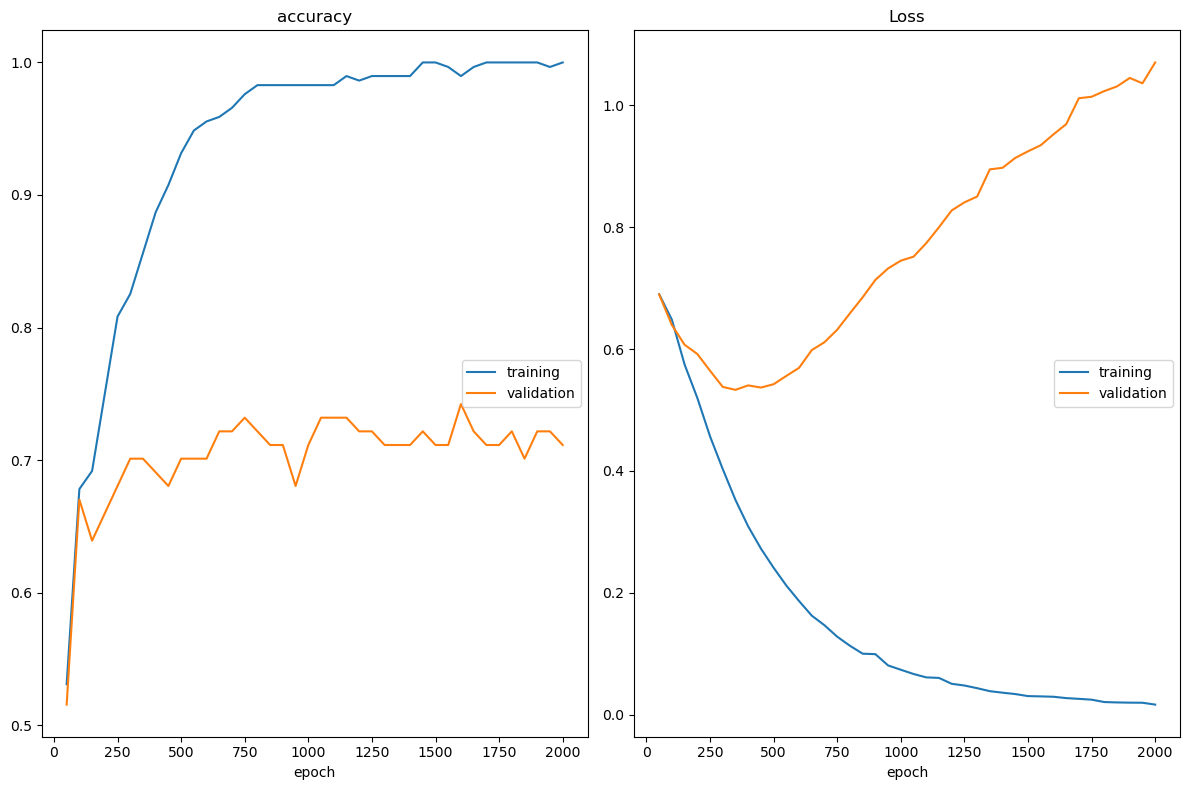

accuracy
	training         	 (min:    0.531, max:    1.000, cur:    1.000)
	validation       	 (min:    0.515, max:    0.742, cur:    0.711)
Loss
	training         	 (min:    0.016, max:    0.690, cur:    0.016)
	validation       	 (min:    0.533, max:    1.070, cur:    1.070)


In [20]:
def train_model_new(model_class, epochs=DEFAULT_EPOCHS, learning_rate=1e-4, **kwargs):
    model = model_class(**kwargs)
    if torch.cuda.is_available():
        model = model.cuda()

    model = torch.nn.DataParallel(model)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    liveloss = livelossplot.PlotLosses()
    for i in range(epochs):
        model.train()

        optimizer.zero_grad(set_to_none=True)
        prediction = model(train_X)
        loss = loss_function(prediction, train_Y)
        loss.backward()
        optimizer.step()

        if (i + 1) % 50 == 0:
            liveloss_updates = {}
            with torch.no_grad():
                model.eval()

                def get_metrics(metrics_prefix, metrics_X, metrics_Y):
                    metrics_prediction = model(metrics_X)

                    return {
                        f"{metrics_prefix}loss": loss_function(metrics_prediction, metrics_Y),
                        f"{metrics_prefix}accuracy": torcheval.metrics.functional.multiclass_accuracy(torch.argmax(metrics_prediction, dim=-1), metrics_Y)
                    }

                liveloss_updates.update(get_metrics("", train_X, train_Y))
                liveloss_updates.update(get_metrics("val_", validation_X, validation_Y))

            liveloss_updates = {k: to_numpy(v) for k, v in liveloss_updates.items()}
            liveloss.update(liveloss_updates,
                            current_step=i+1)
            liveloss.send()

    return model

test_model_new = train_model_new(TreeNetDropHead, epochs=2000)


Give an illustrate how your regularization method does better.
This might be a chart or some numerical representation of the difference.

## Training All Combinations

Train all 16 combinations of the 4 training improvements.
For each combination, plot the loss and accuracy for the training and validation sets during the training process.

Hint: You are strongly encouraged to make a new training function that takes in 4 Boolean parameters controlling the activation of your improvements.
Have this function generate the requested charts too.
This way, you can write the improvement code once each and just call the training function repeatedly with different parameters.

In [16]:
# YOUR CHANGES HERE
test_data_set = load_data_set("test")
for t in test_data_set[1:]:
    print("TEST", t.shape, t.dtype, t.device)
(test_file_names, test_X, test_Y) = test_data_set

SKIPPING  IMG_1108.png (342, 256, 3)
SKIPPING  IMG_1113.png (342, 256, 3)
SKIPPING  IMG_1118.png (342, 256, 3)
TEST torch.Size([97, 3, 192, 256]) torch.float32 cuda:0
TEST torch.Size([97]) torch.int64 cuda:0


In [110]:
import copy
import torch
import torch.nn as nn
from copy import deepcopy
from collections import deque
import numpy as np

combinations = [
    {'id': 0, 'early_stopping': False, 'xavier_init': False, 'lr_scheduler': False, 'dropout': False},
    {'id': 1, 'early_stopping': False, 'xavier_init': False, 'lr_scheduler': False, 'dropout': True},
    {'id': 2, 'early_stopping': False, 'xavier_init': False, 'lr_scheduler': True, 'dropout': False},
    {'id': 3, 'early_stopping': False, 'xavier_init': False, 'lr_scheduler': True, 'dropout': True},
    {'id': 4, 'early_stopping': False, 'xavier_init': True, 'lr_scheduler': False, 'dropout': False},
    {'id': 5, 'early_stopping': False, 'xavier_init': True, 'lr_scheduler': False, 'dropout': True},
    {'id': 6, 'early_stopping': False, 'xavier_init': True, 'lr_scheduler': True, 'dropout': False},
    {'id': 7, 'early_stopping': False, 'xavier_init': True, 'lr_scheduler': True, 'dropout': True},
    {'id': 8, 'early_stopping': True, 'xavier_init': False, 'lr_scheduler': False, 'dropout': False},
    {'id': 9, 'early_stopping': True, 'xavier_init': False, 'lr_scheduler': False, 'dropout': True},
    {'id': 10, 'early_stopping': True, 'xavier_init': False, 'lr_scheduler': True, 'dropout': False},
    {'id': 11, 'early_stopping': True, 'xavier_init': False, 'lr_scheduler': True, 'dropout': True},
    {'id': 12, 'early_stopping': True, 'xavier_init': True, 'lr_scheduler': False, 'dropout': False},
    {'id': 13, 'early_stopping': True, 'xavier_init': True, 'lr_scheduler': False, 'dropout': True},
    {'id': 14, 'early_stopping': True, 'xavier_init': True, 'lr_scheduler': True, 'dropout': False},
    {'id': 15, 'early_stopping': True, 'xavier_init': True, 'lr_scheduler': True, 'dropout': True},
]


def apply_xavier_all(model):
    core = model.module if hasattr(model, "module") else model
    for m in core.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.xavier_normal_(m.weight)  # ← Use Xavier
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def train_with_improvements(
    use_early_stopping: bool,
    use_xavier_init: bool,
    use_lr_scheduler: bool,     
    use_dropout: bool,
    max_epochs: int = 2000,
):
    torch.manual_seed(36)  
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Print configuration
    print(f"\nTraining with: ES={use_early_stopping}, Init={use_xavier_init}, "
          f"Scheduler={'RLP' if use_lr_scheduler else 'None'}, "
          f"Dropout={'true' if use_dropout else None}")
    BASE_LR = 1e-4

    # Data to device 
    train_X_d, train_Y_d = train_X.to(device), train_Y.to(device)
    val_X_d,   val_Y_d   = validation_X.to(device), validation_Y.to(device)
    test_X_d,  test_Y_d  = test_X.to(device), test_Y.to(device)

    # Model
    model = (TreeNetDropHead(p=0.3) if use_dropout else TreeNetwork()).to(device)
    if use_xavier_init:
        apply_xavier_all(model)  
    model = nn.DataParallel(model)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR)
    
    # LR Scheduler 
    scheduler = None
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.7,       
            patience=50,        
            threshold=1e-3,    
            threshold_mode='rel',
            cooldown=0,
            min_lr=3e-5,
        )
        
    # Early stopping state
    smooth_k   = 7      
    min_epochs = 100    
    patience   = 150     
    min_delta  = 1e-3  

    val_window = deque(maxlen=smooth_k)
    best_val_smoothed = float('inf')
    best_model_state  = None
    best_epoch        = 0
    epochs_no_improve = 0

    # History
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch': []}

    for epoch in range(max_epochs):
        # Train
        model.train()
        optimizer.zero_grad(set_to_none=True)
        logits_train = model(train_X_d)
        loss = loss_function(logits_train, train_Y_d)
        loss.backward()
        optimizer.step()

        # Metrics 
        model.eval()
        with torch.no_grad():
            train_loss = float(loss)  
            train_acc  = (logits_train.argmax(-1) == train_Y_d).float().mean().item()

            logits_val = model(val_X_d)
            val_loss   = loss_function(logits_val, val_Y_d).item()
            val_acc    = (logits_val.argmax(-1) == val_Y_d).float().mean().item()
            
        prev_lr = optimizer.param_groups[0]['lr']
        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        new_lr = optimizer.param_groups[0]['lr']
        if new_lr < prev_lr:
            print(f"  LR reduced: {prev_lr:.2e} -> {new_lr:.2e} (epoch {epoch+1})")

        # Log
        history['epoch'].append(epoch+1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Early-stopping bookkeeping
        val_window.append(val_loss)
        val_smoothed = np.median(val_window) if len(val_window) == smooth_k else val_loss

        improved = (val_smoothed + min_delta) < best_val_smoothed
        if improved:
            best_val_smoothed = val_smoothed
            best_model_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch + 1
            epochs_no_improve = 0
        else:
            if (epoch + 1) >= min_epochs:
                epochs_no_improve += 1

        if use_early_stopping and (epoch + 1) >= min_epochs and epochs_no_improve >= patience:
            print(f"  Early stopped at epoch {epoch+1} "
                  f"(best @ {best_epoch}, smoothed val={best_val_smoothed:.4f})")
            break

        if (epoch + 1) % 200 == 0:
            print(f"  Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")

    if use_early_stopping and best_model_state is not None:
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        final_train_acc = (model(train_X_d).argmax(-1) == train_Y_d).float().mean().item()
        final_val_acc   = (model(val_X_d).argmax(-1)   == val_Y_d).float().mean().item()
        test_acc        = (model(test_X_d).argmax(-1)  == test_Y_d).float().mean().item()

    history['final_train_acc'] = final_train_acc
    history['final_val_acc']   = final_val_acc
    history['test_acc']        = test_acc
    history['best_epoch']      = best_epoch
    history['best_val_loss']   = best_val_smoothed

    print(f"  Finished: {len(history['epoch'])} epochs, best @ {best_epoch}, "
          f" train acc = {final_train_acc:.3f}, final val acc={final_val_acc:.3f}, test acc={test_acc:.3f}")
    return model, history

def plot_training_curves(history, model_id, description):  
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    epochs = history['epoch']
    best_epoch = history.get('best_epoch', None)

    # Loss plot
    ax1.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Training')
    ax1.plot(epochs, history['val_loss'], 'orange', linewidth=2, label='Validation')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'Model {model_id}: Loss', fontsize=13, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, history['train_acc'], 'b-', linewidth=2, label='Training')
    ax2.plot(epochs, history['val_acc'], 'orange', linewidth=2, label='Validation')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'Model {model_id}: Accuracy', fontsize=13, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0.5, 1.05])

    plt.suptitle(f'Model {model_id}: {description}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()



Training Model 0: Baseline

Training with: ES=False, Init=False, Scheduler=None, Dropout=None
  Epoch 200: train_acc=0.791, val_acc=0.804
  Epoch 400: train_acc=0.836, val_acc=0.794
  Epoch 600: train_acc=0.887, val_acc=0.742
  Epoch 800: train_acc=0.962, val_acc=0.753
  Epoch 1000: train_acc=0.986, val_acc=0.742
  Epoch 1200: train_acc=1.000, val_acc=0.732
  Epoch 1400: train_acc=1.000, val_acc=0.722
  Epoch 1600: train_acc=1.000, val_acc=0.722
  Epoch 1800: train_acc=1.000, val_acc=0.722
  Epoch 2000: train_acc=1.000, val_acc=0.722
  Finished: 2000 epochs, best @ 451,  train acc = 1.000, final val acc=0.722, test acc=0.670
Saved model_00.pt


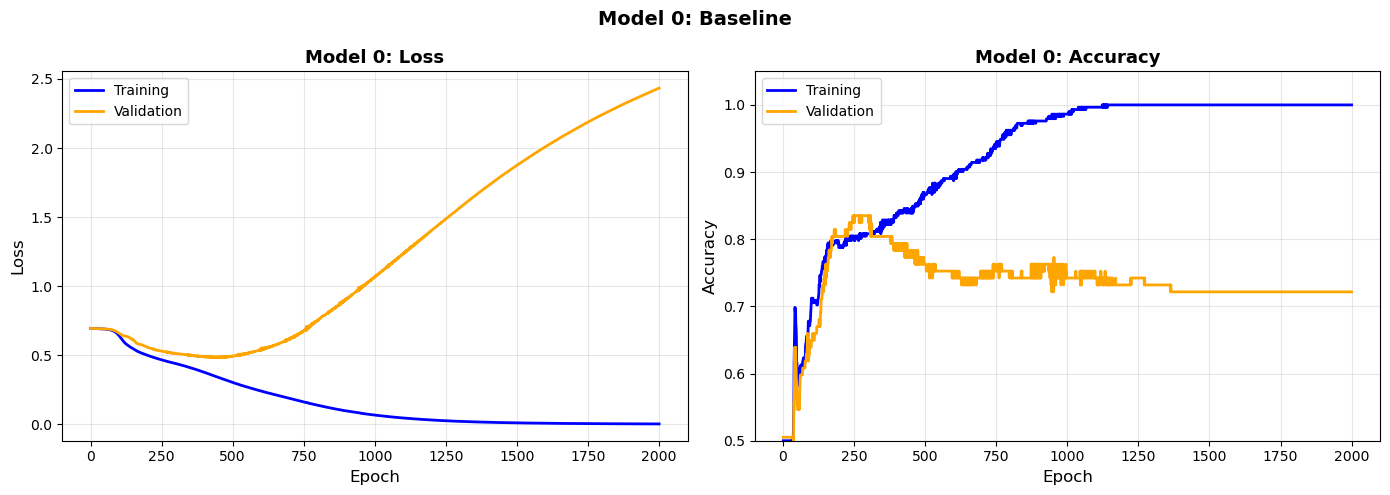


Training Model 1: Dropout

Training with: ES=False, Init=False, Scheduler=None, Dropout=true
  Epoch 200: train_acc=0.784, val_acc=0.804
  Epoch 400: train_acc=0.791, val_acc=0.814
  Epoch 600: train_acc=0.825, val_acc=0.814
  Epoch 800: train_acc=0.856, val_acc=0.825
  Epoch 1000: train_acc=0.870, val_acc=0.814
  Epoch 1200: train_acc=0.894, val_acc=0.825
  Epoch 1400: train_acc=0.942, val_acc=0.804
  Epoch 1600: train_acc=0.945, val_acc=0.825
  Epoch 1800: train_acc=0.969, val_acc=0.794
  Epoch 2000: train_acc=0.959, val_acc=0.804
  Finished: 2000 epochs, best @ 1021,  train acc = 0.990, final val acc=0.804, test acc=0.742
Saved model_01.pt


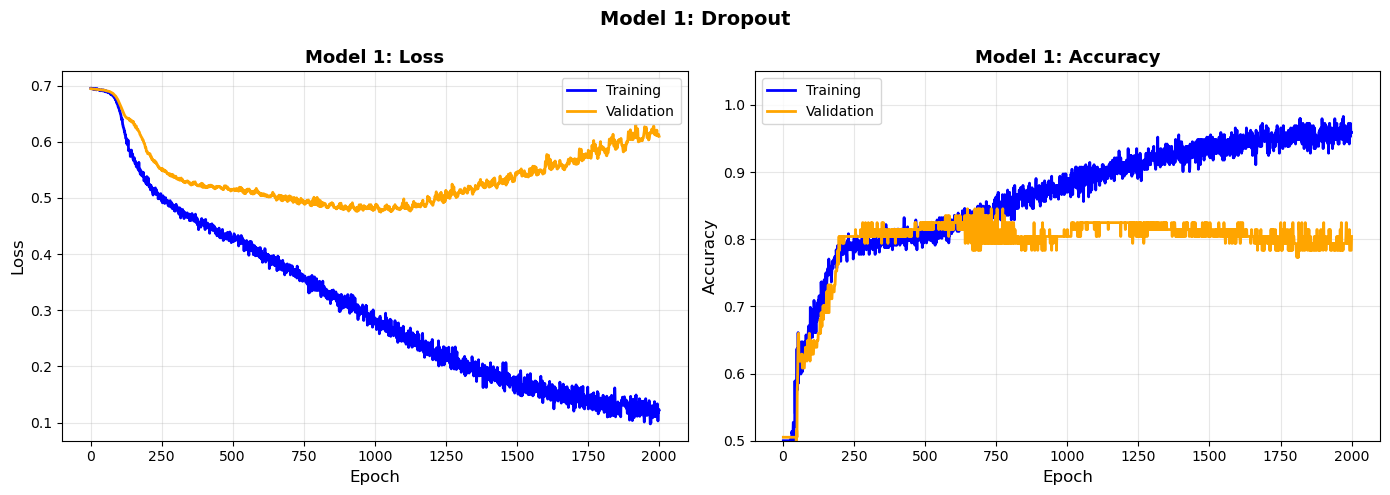


Training Model 2: UseLRScheduler

Training with: ES=False, Init=False, Scheduler=RLP, Dropout=None
  Epoch 200: train_acc=0.788, val_acc=0.804
  Epoch 400: train_acc=0.839, val_acc=0.794
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 477)
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 528)
  LR reduced: 4.90e-05 -> 3.43e-05 (epoch 579)
  Epoch 600: train_acc=0.880, val_acc=0.753
  LR reduced: 3.43e-05 -> 3.00e-05 (epoch 630)
  Epoch 800: train_acc=0.901, val_acc=0.732
  Epoch 1000: train_acc=0.921, val_acc=0.753
  Epoch 1200: train_acc=0.966, val_acc=0.753
  Epoch 1400: train_acc=0.976, val_acc=0.742
  Epoch 1600: train_acc=0.993, val_acc=0.722
  Epoch 1800: train_acc=1.000, val_acc=0.732
  Epoch 2000: train_acc=1.000, val_acc=0.732
  Finished: 2000 epochs, best @ 426,  train acc = 1.000, final val acc=0.732, test acc=0.701
Saved model_02.pt


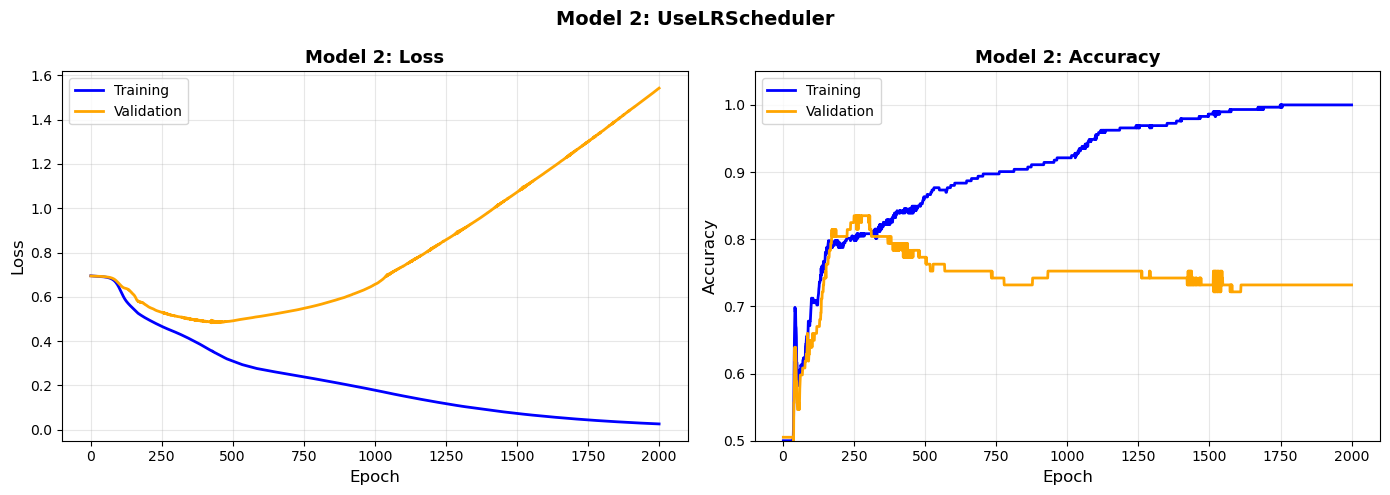


Training Model 3: UseLRScheduler + Dropout

Training with: ES=False, Init=False, Scheduler=RLP, Dropout=true
  Epoch 200: train_acc=0.777, val_acc=0.804
  Epoch 400: train_acc=0.791, val_acc=0.814
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 592)
  Epoch 600: train_acc=0.825, val_acc=0.814
  Epoch 800: train_acc=0.839, val_acc=0.835
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 989)
  Epoch 1000: train_acc=0.870, val_acc=0.794
  LR reduced: 4.90e-05 -> 3.43e-05 (epoch 1040)
  LR reduced: 3.43e-05 -> 3.00e-05 (epoch 1091)
  Epoch 1200: train_acc=0.866, val_acc=0.794
  Epoch 1400: train_acc=0.908, val_acc=0.804
  Epoch 1600: train_acc=0.887, val_acc=0.804
  Epoch 1800: train_acc=0.897, val_acc=0.804
  Epoch 2000: train_acc=0.901, val_acc=0.814
  Finished: 2000 epochs, best @ 937,  train acc = 0.921, final val acc=0.814, test acc=0.753
Saved model_03.pt


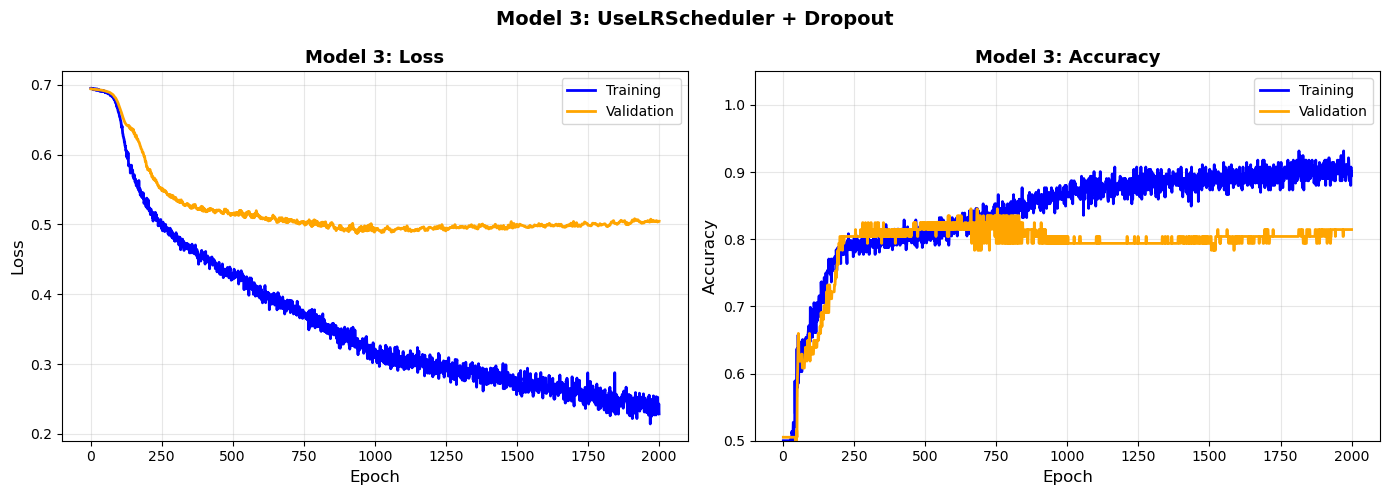


Training Model 4: XavierInit

Training with: ES=False, Init=True, Scheduler=None, Dropout=None
  Epoch 200: train_acc=0.791, val_acc=0.701
  Epoch 400: train_acc=0.962, val_acc=0.732
  Epoch 600: train_acc=1.000, val_acc=0.732
  Epoch 800: train_acc=1.000, val_acc=0.732
  Epoch 1000: train_acc=1.000, val_acc=0.742
  Epoch 1200: train_acc=1.000, val_acc=0.742
  Epoch 1400: train_acc=1.000, val_acc=0.742
  Epoch 1600: train_acc=1.000, val_acc=0.742
  Epoch 1800: train_acc=1.000, val_acc=0.753
  Epoch 2000: train_acc=1.000, val_acc=0.753
  Finished: 2000 epochs, best @ 253,  train acc = 1.000, final val acc=0.753, test acc=0.680
Saved model_04.pt


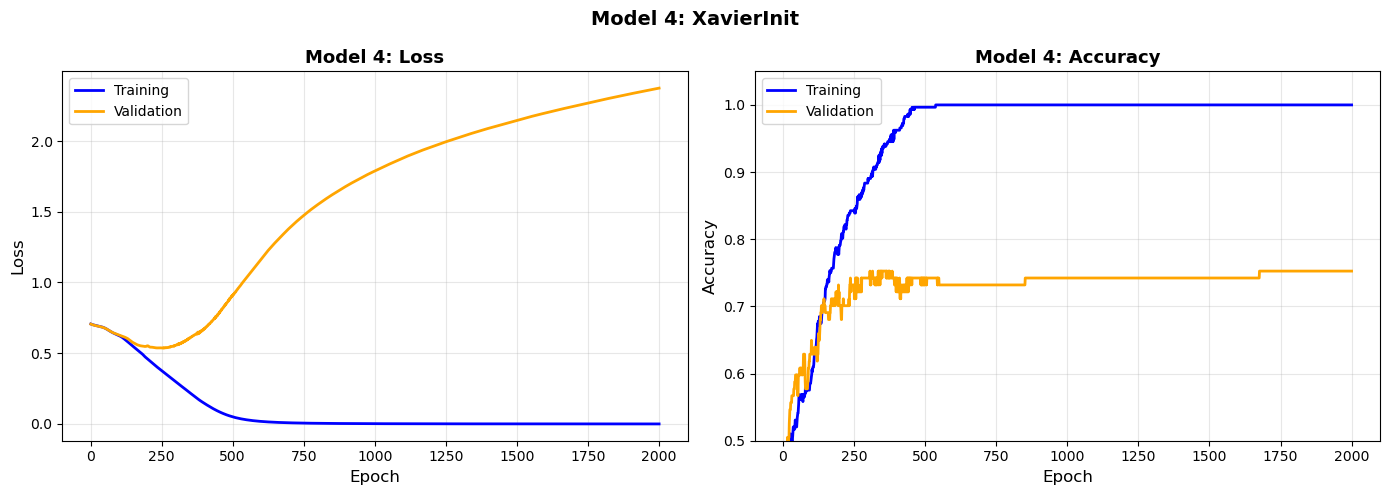


Training Model 5: XavierInit + Dropout

Training with: ES=False, Init=True, Scheduler=None, Dropout=true
  Epoch 200: train_acc=0.682, val_acc=0.619
  Epoch 400: train_acc=0.788, val_acc=0.753
  Epoch 600: train_acc=0.884, val_acc=0.753
  Epoch 800: train_acc=0.887, val_acc=0.784
  Epoch 1000: train_acc=0.904, val_acc=0.763
  Epoch 1200: train_acc=0.945, val_acc=0.784
  Epoch 1400: train_acc=0.942, val_acc=0.763
  Epoch 1600: train_acc=0.949, val_acc=0.773
  Epoch 1800: train_acc=0.949, val_acc=0.753
  Epoch 2000: train_acc=0.966, val_acc=0.784
  Finished: 2000 epochs, best @ 559,  train acc = 0.997, final val acc=0.784, test acc=0.732
Saved model_05.pt


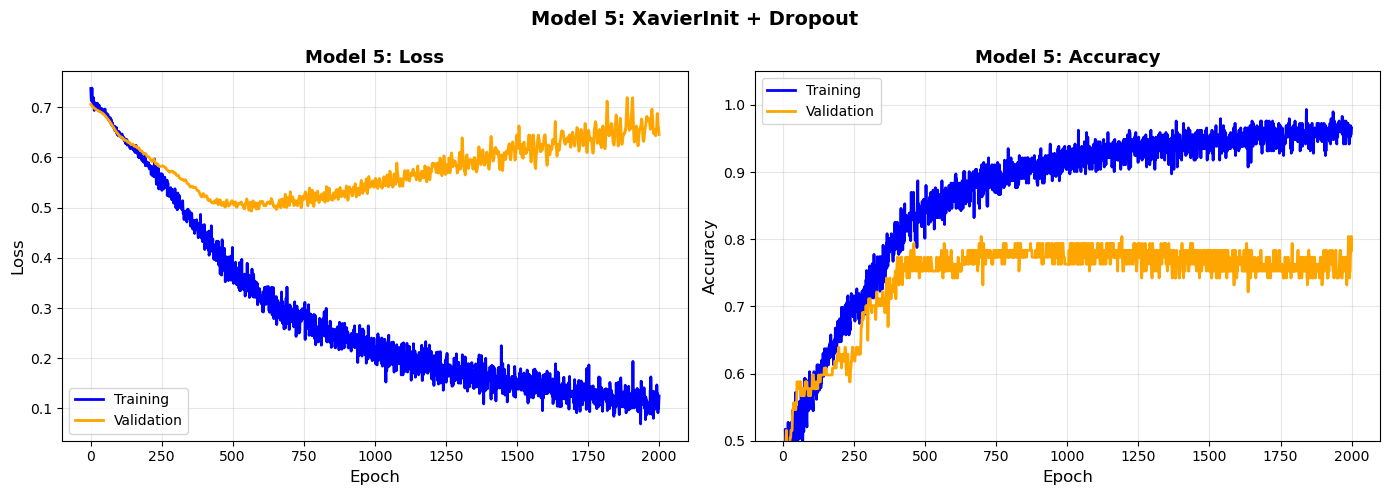


Training Model 6: XavierInit + UseLRScheduler

Training with: ES=False, Init=True, Scheduler=RLP, Dropout=None
  Epoch 200: train_acc=0.791, val_acc=0.701
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 301)
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 352)
  Epoch 400: train_acc=0.945, val_acc=0.753
  LR reduced: 4.90e-05 -> 3.43e-05 (epoch 403)
  LR reduced: 3.43e-05 -> 3.00e-05 (epoch 454)
  Epoch 600: train_acc=0.986, val_acc=0.722
  Epoch 800: train_acc=1.000, val_acc=0.732
  Epoch 1000: train_acc=1.000, val_acc=0.742
  Epoch 1200: train_acc=1.000, val_acc=0.742
  Epoch 1400: train_acc=1.000, val_acc=0.753
  Epoch 1600: train_acc=1.000, val_acc=0.742
  Epoch 1800: train_acc=1.000, val_acc=0.742
  Epoch 2000: train_acc=1.000, val_acc=0.742
  Finished: 2000 epochs, best @ 239,  train acc = 1.000, final val acc=0.742, test acc=0.691
Saved model_06.pt


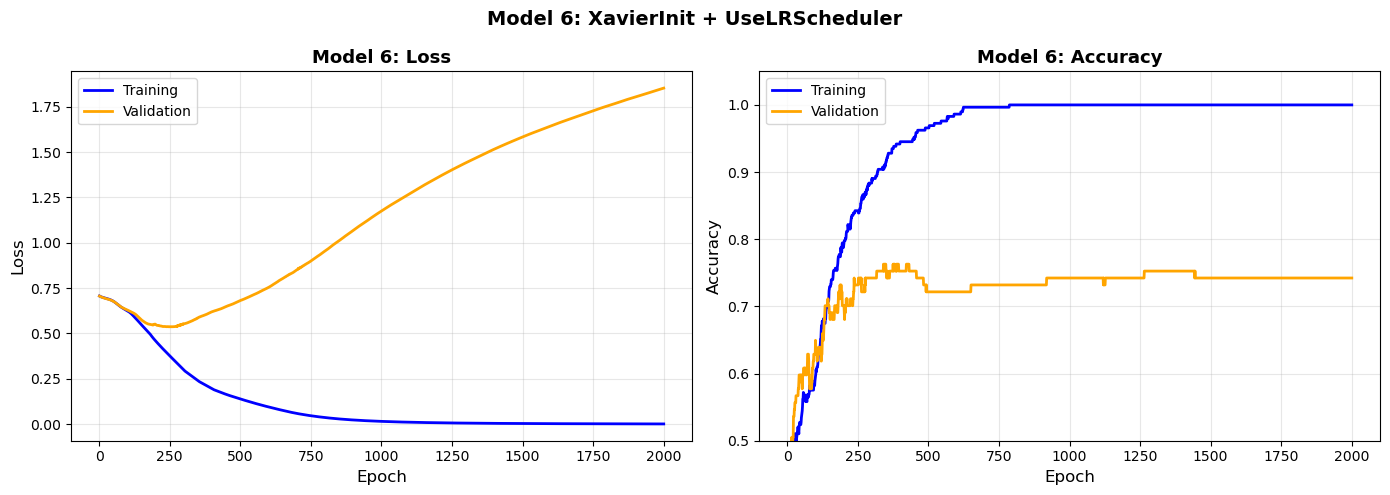


Training Model 7: XavierInit + UseLRScheduler + Dropout

Training with: ES=False, Init=True, Scheduler=RLP, Dropout=true
  Epoch 200: train_acc=0.685, val_acc=0.619
  Epoch 400: train_acc=0.791, val_acc=0.742
  Epoch 600: train_acc=0.884, val_acc=0.773
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 609)
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 660)
  LR reduced: 4.90e-05 -> 3.43e-05 (epoch 711)
  LR reduced: 3.43e-05 -> 3.00e-05 (epoch 762)
  Epoch 800: train_acc=0.873, val_acc=0.794
  Epoch 1000: train_acc=0.911, val_acc=0.784
  Epoch 1200: train_acc=0.908, val_acc=0.773
  Epoch 1400: train_acc=0.901, val_acc=0.773
  Epoch 1600: train_acc=0.938, val_acc=0.794
  Epoch 1800: train_acc=0.904, val_acc=0.773
  Epoch 2000: train_acc=0.925, val_acc=0.794
  Finished: 2000 epochs, best @ 585,  train acc = 0.973, final val acc=0.794, test acc=0.701
Saved model_07.pt


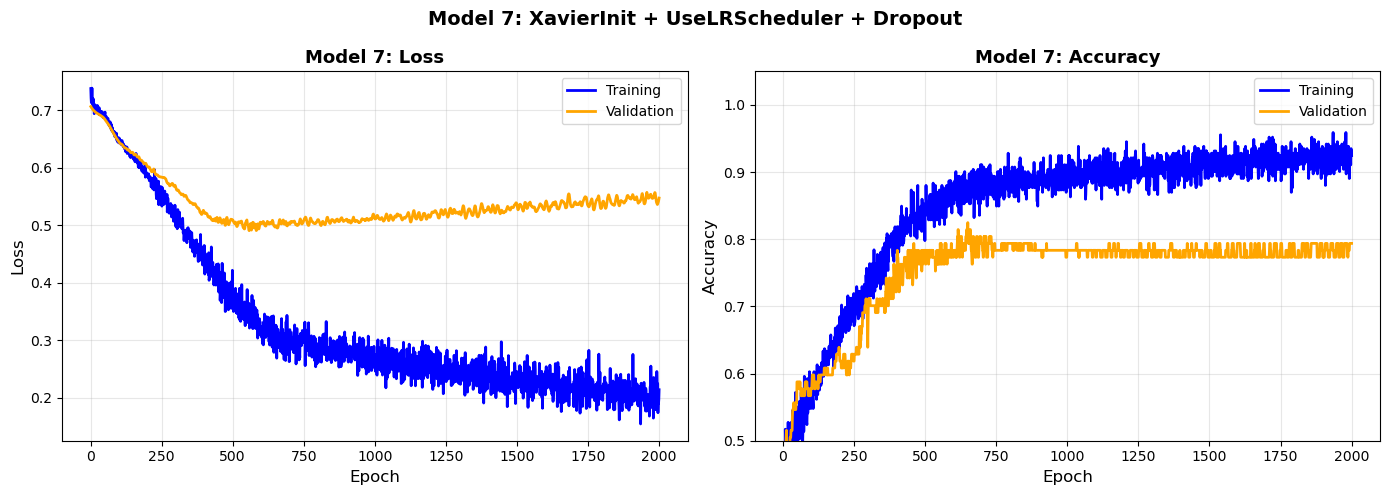


Training Model 8: EarlyStopping

Training with: ES=True, Init=False, Scheduler=None, Dropout=None
  Epoch 200: train_acc=0.791, val_acc=0.804
  Epoch 400: train_acc=0.839, val_acc=0.794
  Epoch 600: train_acc=0.897, val_acc=0.753
  Early stopped at epoch 606 (best @ 456, smoothed val=0.4843)
  Finished: 606 epochs, best @ 456,  train acc = 0.849, final val acc=0.773, test acc=0.680
Saved model_08.pt


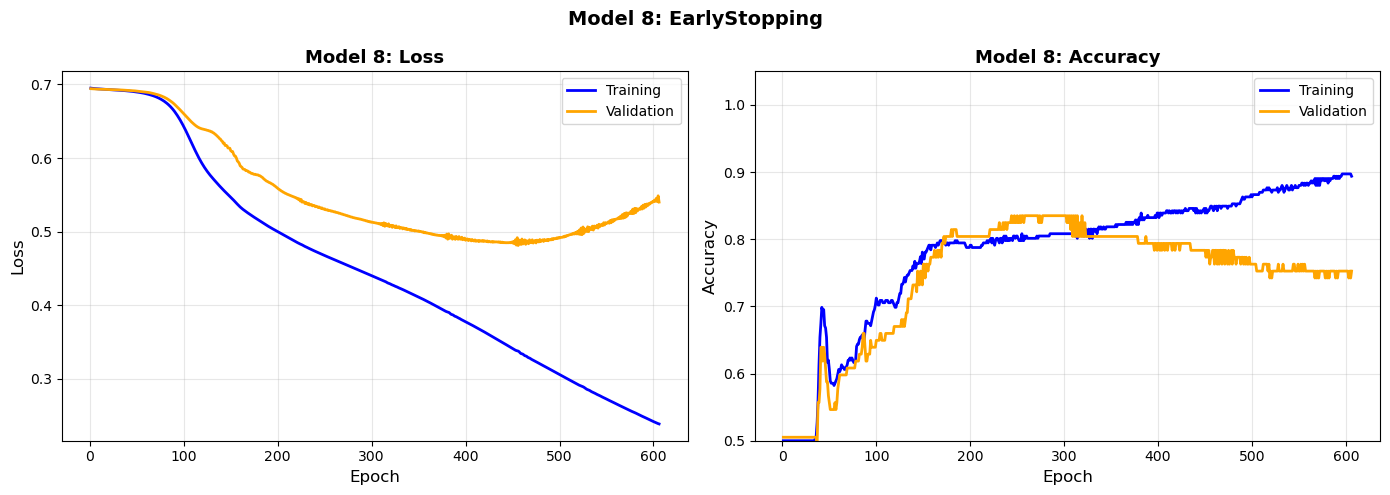


Training Model 9: EarlyStopping + Dropout

Training with: ES=True, Init=False, Scheduler=None, Dropout=true
  Epoch 200: train_acc=0.781, val_acc=0.804
  Epoch 400: train_acc=0.791, val_acc=0.804
  Epoch 600: train_acc=0.829, val_acc=0.814
  Epoch 800: train_acc=0.849, val_acc=0.814
  Epoch 1000: train_acc=0.873, val_acc=0.804
  Early stopped at epoch 1171 (best @ 1021, smoothed val=0.4791)
  Finished: 1171 epochs, best @ 1021,  train acc = 0.901, final val acc=0.825, test acc=0.711
Saved model_09.pt


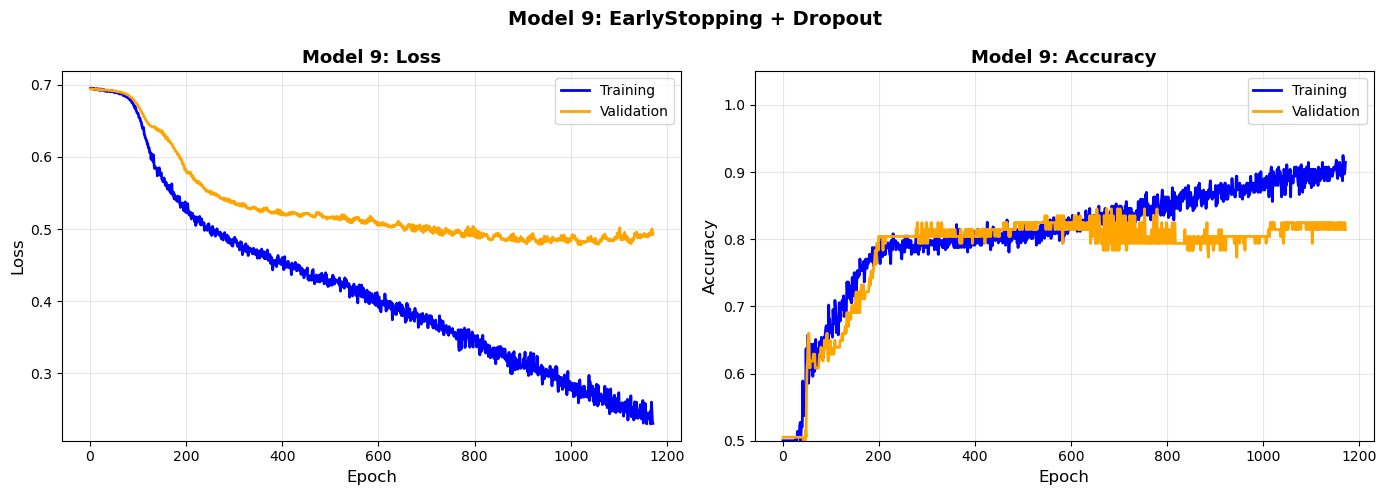


Training Model 10: EarlyStopping + UseLRScheduler

Training with: ES=True, Init=False, Scheduler=RLP, Dropout=None
  Epoch 200: train_acc=0.791, val_acc=0.804
  Epoch 400: train_acc=0.839, val_acc=0.794
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 482)
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 533)
  LR reduced: 4.90e-05 -> 3.43e-05 (epoch 584)
  Epoch 600: train_acc=0.884, val_acc=0.753
  Early stopped at epoch 601 (best @ 451, smoothed val=0.4860)
  Finished: 601 epochs, best @ 451,  train acc = 0.842, final val acc=0.784, test acc=0.670
Saved model_10.pt


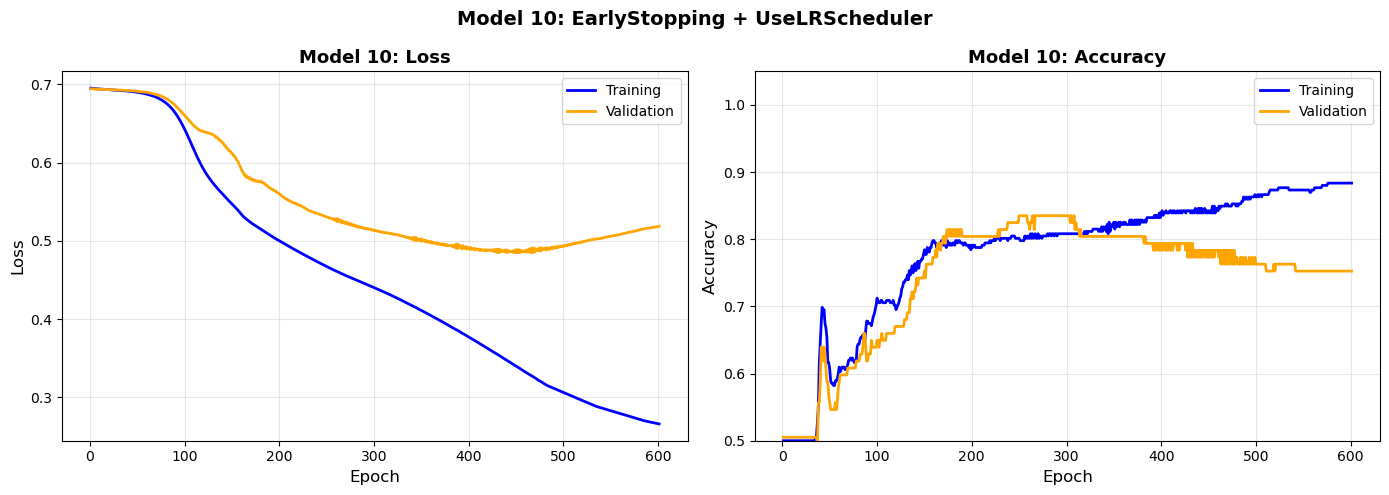


Training Model 11: EarlyStopping + UseLRScheduler + Dropout

Training with: ES=True, Init=False, Scheduler=RLP, Dropout=true
  Epoch 200: train_acc=0.788, val_acc=0.804
  Epoch 400: train_acc=0.791, val_acc=0.804
  Epoch 600: train_acc=0.825, val_acc=0.814
  Epoch 800: train_acc=0.846, val_acc=0.825
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 959)
  Epoch 1000: train_acc=0.877, val_acc=0.814
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 1010)
  Early stopped at epoch 1058 (best @ 908, smoothed val=0.4789)
  Finished: 1058 epochs, best @ 908,  train acc = 0.877, final val acc=0.825, test acc=0.722
Saved model_11.pt


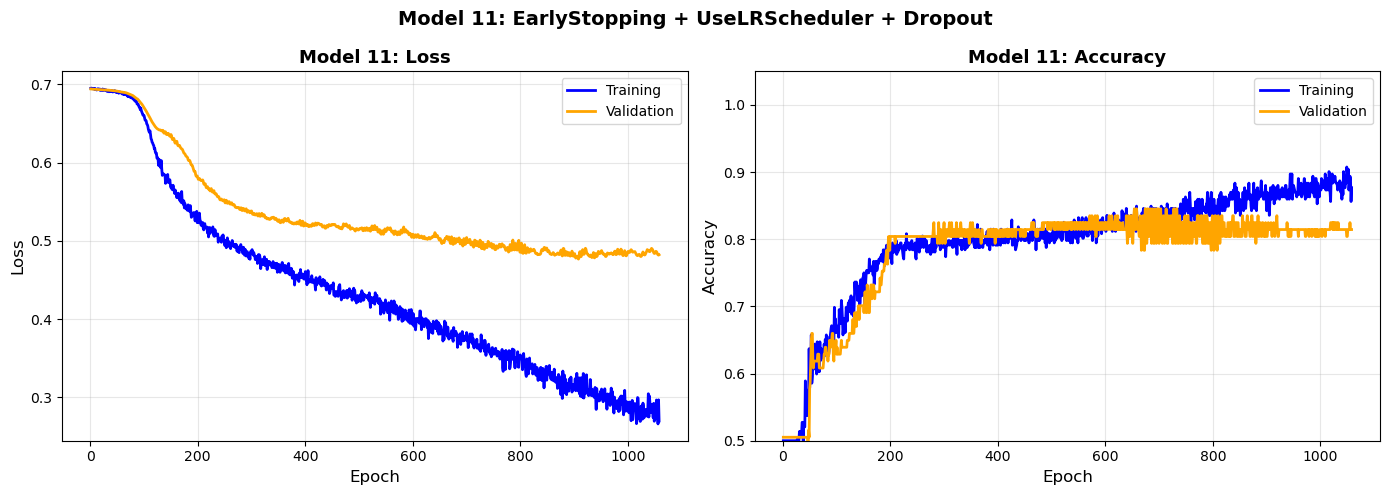


Training Model 12: EarlyStopping + XavierInit

Training with: ES=True, Init=True, Scheduler=None, Dropout=None
  Epoch 200: train_acc=0.788, val_acc=0.701
  Early stopped at epoch 392 (best @ 242, smoothed val=0.5381)
  Finished: 392 epochs, best @ 242,  train acc = 0.842, final val acc=0.732, test acc=0.691
Saved model_12.pt


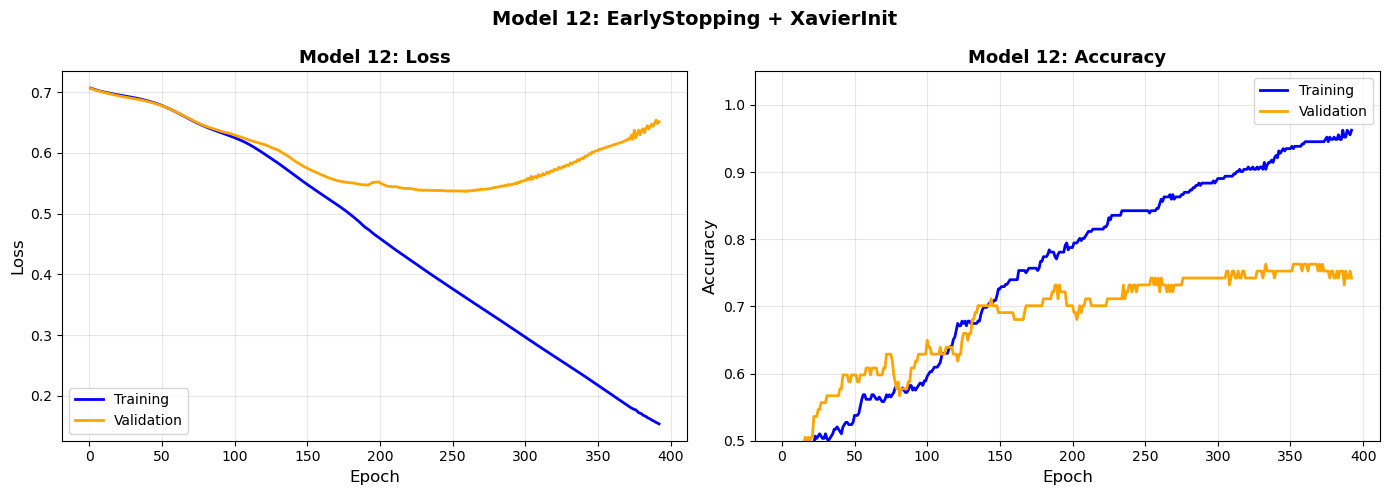


Training Model 13: EarlyStopping + XavierInit + Dropout

Training with: ES=True, Init=True, Scheduler=None, Dropout=true
  Epoch 200: train_acc=0.678, val_acc=0.619
  Epoch 400: train_acc=0.784, val_acc=0.753
  Epoch 600: train_acc=0.880, val_acc=0.763
  Early stopped at epoch 692 (best @ 542, smoothed val=0.4996)
  Finished: 692 epochs, best @ 542,  train acc = 0.897, final val acc=0.763, test acc=0.691
Saved model_13.pt


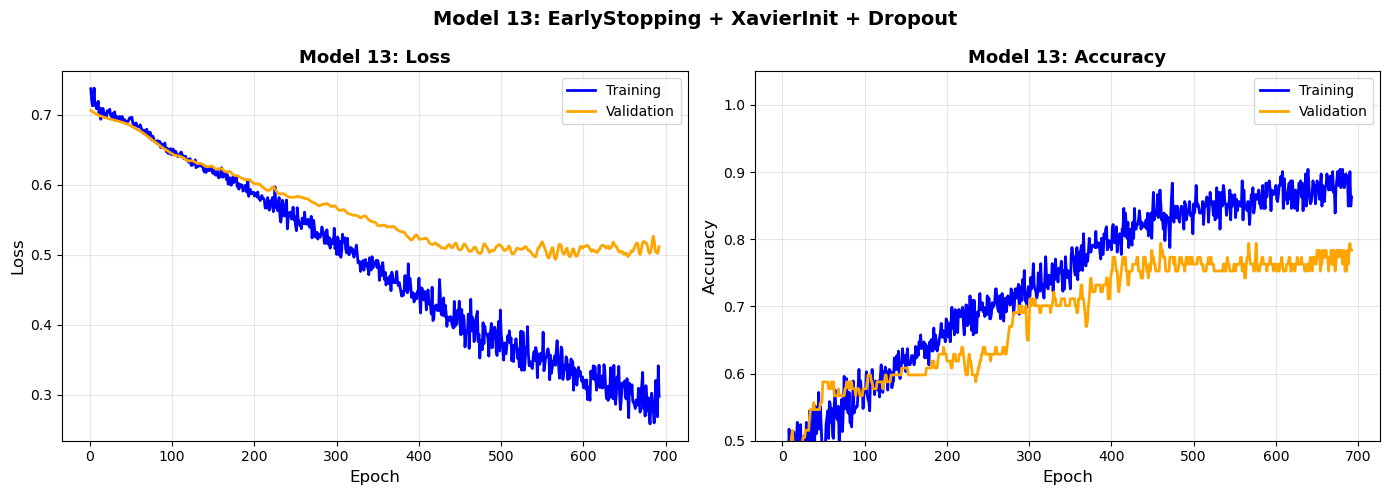


Training Model 14: EarlyStopping + XavierInit + UseLRScheduler

Training with: ES=True, Init=True, Scheduler=RLP, Dropout=None
  Epoch 200: train_acc=0.788, val_acc=0.701
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 285)
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 336)
  Early stopped at epoch 383 (best @ 233, smoothed val=0.5380)
  Finished: 383 epochs, best @ 233,  train acc = 0.839, final val acc=0.701, test acc=0.691
Saved model_14.pt


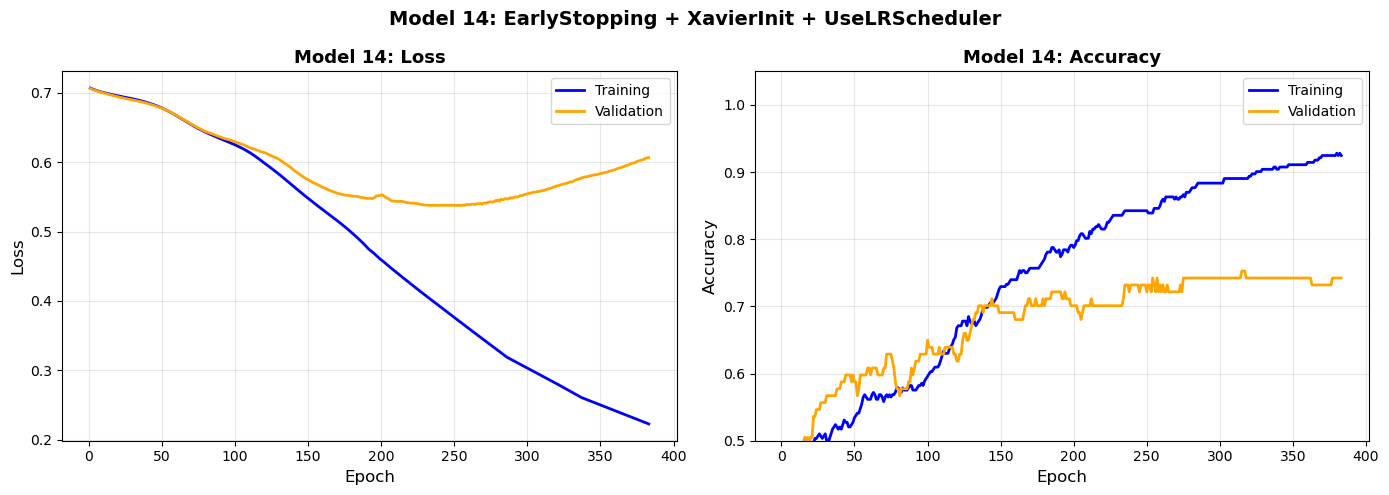


Training Model 15: EarlyStopping + XavierInit + UseLRScheduler + Dropout

Training with: ES=True, Init=True, Scheduler=RLP, Dropout=true
  Epoch 200: train_acc=0.678, val_acc=0.619
  Epoch 400: train_acc=0.781, val_acc=0.742
  Epoch 600: train_acc=0.887, val_acc=0.753
  LR reduced: 1.00e-04 -> 7.00e-05 (epoch 617)
  LR reduced: 7.00e-05 -> 4.90e-05 (epoch 668)
  Early stopped at epoch 692 (best @ 542, smoothed val=0.5006)
  Finished: 692 epochs, best @ 542,  train acc = 0.901, final val acc=0.763, test acc=0.701
Saved model_15.pt


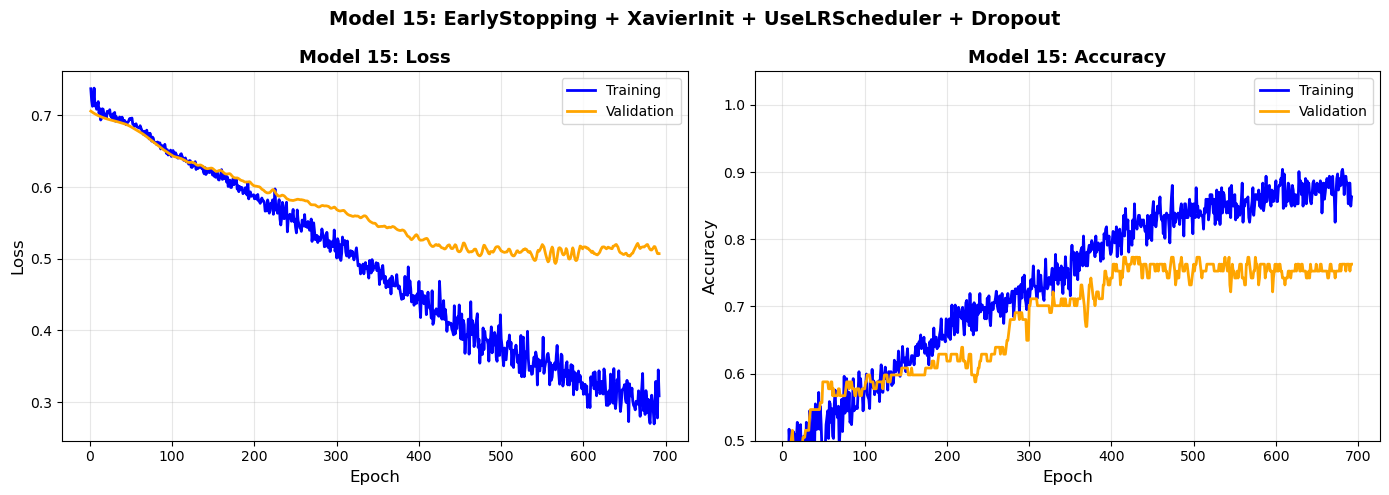

In [111]:

all_models = []
all_histories = []

for combo in combinations:
    model_id = combo['id']
    
    # Build description
    improvements = []
    if combo['early_stopping']: improvements.append("EarlyStopping")
    if combo['xavier_init']: improvements.append("XavierInit")
    if combo['lr_scheduler']: improvements.append("UseLRScheduler")
    if combo['dropout']: improvements.append("Dropout")
    description = " + ".join(improvements) if improvements else "Baseline"
    
    print(f"\n{'='*80}")
    print(f"Training Model {model_id}: {description}")
    print(f"{'='*80}")
    
    # Train
    model, history = train_with_improvements(
        use_early_stopping=combo['early_stopping'],
        use_xavier_init=combo['xavier_init'],
        use_lr_scheduler=combo['lr_scheduler'],
        use_dropout=combo['dropout'],
        max_epochs=2000
    )

    def _cpu_state_dict(m):
        sd = m.module.state_dict() if hasattr(m, "module") else m.state_dict()
        return {k: v.detach().cpu() for k, v in sd.items()}

    ckpt = {
    "model_id": combo['id'],
    "config": copy.deepcopy(combo) | {"p_drop": 0.10},  # keep dropout prob you used
    "best_epoch": history.get("best_epoch", None),
    "metrics": {
        "final_train_acc": history["final_train_acc"],
        "final_val_acc": history["final_val_acc"],
        "test_acc": history["test_acc"],
        "best_val_loss": history.get("best_val_loss", None),
    },
    "state_dict": _cpu_state_dict(model),
}
    ckpt_path = f"model_{combo['id']:02d}.pt"   # saved in current working dir
    torch.save(ckpt, ckpt_path)
    print(f"Saved {ckpt_path}")
    
    # Store
    all_models.append(model)
    all_histories.append(history)
    
    # Plot
    plot_training_curves(history, model_id, description)


In [112]:
print("\nModel | Early Stop | Init  | LR    | Dropout | Train Acc | Val Acc | Test Acc")
print("------|------------|-------|-------|---------|-----------|---------|----------")

for combo, history in zip(combinations, all_histories):
    i = combo['id']
    es = "true " if combo['early_stopping'] else "false"
    init = "true " if combo['xavier_init'] else "false"
    lr = "true " if combo['lr_scheduler'] else "false"
    drop = "true " if combo['dropout'] else "false"
    
    train_acc = history['final_train_acc']
    val_acc = history['final_val_acc']
    test_acc = history['test_acc']
    
    print(f"  {i:2d}  |   {es}    | {init}  | {lr}  |  {drop}   |  {train_acc:.4f}   | {val_acc:.4f}  | {test_acc:.4f}")


Model | Early Stop | Init  | LR    | Dropout | Train Acc | Val Acc | Test Acc
------|------------|-------|-------|---------|-----------|---------|----------
   0  |   false    | false  | false  |  false   |  1.0000   | 0.7216  | 0.6701
   1  |   false    | false  | false  |  true    |  0.9897   | 0.8041  | 0.7423
   2  |   false    | false  | true   |  false   |  1.0000   | 0.7320  | 0.7010
   3  |   false    | false  | true   |  true    |  0.9212   | 0.8144  | 0.7526
   4  |   false    | true   | false  |  false   |  1.0000   | 0.7526  | 0.6804
   5  |   false    | true   | false  |  true    |  0.9966   | 0.7835  | 0.7320
   6  |   false    | true   | true   |  false   |  1.0000   | 0.7423  | 0.6907
   7  |   false    | true   | true   |  true    |  0.9726   | 0.7938  | 0.7010
   8  |   true     | false  | false  |  false   |  0.8493   | 0.7732  | 0.6804
   9  |   true     | false  | false  |  true    |  0.9007   | 0.8247  | 0.7113
  10  |   true     | false  | true   |  false   |  0

Hint: you may want to save your models with `torch.save` to save retraining time later after receiving the new validation set in a week.

### Make a Table Comparing the Combinations

Fill in the chart below with the final results of each training run.

YOUR CHANGES HERE

| Early Stopping | Initialization | Learning Rate | Regularization | Training Accuracy | Validation Accuracy | Test Accuracy |
|---|---|---|---|---:|---:|---:|
| false | false | false | false | 1.00 | 0.7216 | 0.6701 |
| false | false | false | true | 0.9897 | 0.8041 | 0.7423 |
| false | false | true | false | 1.00 | 0.7320 | 0.7010 |
| false | false | true | true | 0.9212 | 0.8144 | 0.7526 |
| false | true | false | false | 1.00 | 0.7526 | 0.6804 |
| false | true | false | true | 0.9966 | 0.7835 | 0.7320 |
| false | true | true | false | 1.00 | 0.7423 | 0.6907 |
| false | true | true | true | 0.9726 | 0.7938 | 0.7010 |
| true | false | false | false | 0.8493 | 0.7732 | 0.6804 |
| true | false | false | true | 0.9007 | 0.8247 | 0.7113 |
| true | false | true | false | 0.8425 | 0.7835 | 0.6701 |
| true | false | true | true | 0.8767 | 0.8247 | 0.7216 |
| true | true | false | false | 0.8425 | 0.7320 | 0.6907 |
| true | true | false | true | 0.8973 | 0.7629 | 0.6907 |
| true | true | true | false | 0.8390 | 0.7010  | 0.6907 |
| true | true | true | true | 0.9007 | 0.7629 | 0.7010 |


## Validate Again

Test your models again with the new validation2 data (to be posted 10/13).
Use your existing models trained and do not retrain them using the validation2 data.
Fill in the table below with your validation2 accuracies.

In [81]:
val2_data_set = load_data_set("validation2")   # sometimes "validate2" depending on your helper
for t in val2_data_set[1:]:
    print("VAL2", t.shape, t.dtype, t.device)

(validate2_file_names, validate2_X, validate2_Y) = val2_data_set

SKIPPING  IMG_1585.png (256, 192, 3)
VAL2 torch.Size([108, 3, 192, 256]) torch.float32 cuda:0
VAL2 torch.Size([108]) torch.int64 cuda:0


In [113]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

@torch.no_grad()
def eval_on_split(model, X, Y, device):
    model.eval()
    logits = model(X.to(device))
    loss = loss_function(logits, Y.to(device)).item()
    acc  = (logits.argmax(-1) == Y.to(device)).float().mean().item()
    return loss, acc

def build_model_from_cfg(cfg):
    # Recreate the SAME architecture used during training
    use_dropout = bool(cfg.get("dropout", False))
    p_drop = float(cfg.get("p_drop", 0.10))
    m = TreeNetDropHead(p=p_drop) if use_dropout else TreeNetwork()
    m = m.to(device)
    m = torch.nn.DataParallel(m)  # keep if you trained with DP
    return m

print("\n=== Validate2 results (from disk) ===")
for fname in sorted(os.listdir(".")):
    if not (fname.startswith("model_") and fname.endswith(".pt")):
        continue
    ckpt = torch.load(fname, map_location='cpu', weights_only=False)
    cfg  = ckpt.get("config", {})
    mid  = ckpt.get("model_id", None)

    model = build_model_from_cfg(cfg)
    state = ckpt["state_dict"]
    if hasattr(model, "module"):           # model is DataParallel(...)
        model.module.load_state_dict(state, strict=True)
    else:                                   # plain (non-DP) model
        model.load_state_dict(state, strict=True)

    val2_loss, val2_acc = eval_on_split(model, validate2_X, validate2_Y, device)
    print(f"[{fname}] id={mid:02d} | ES={cfg.get('early_stopping', False)}, "
          f"Init={cfg.get('xavier_init', False)}, LRS={cfg.get('lr_scheduler', False)}, "
          f"Dropout={cfg.get('dropout', False)} | val2 loss={val2_loss:.4f}, acc={val2_acc:.4f}")


=== Validate2 results (from disk) ===
[model_00.pt] id=00 | ES=False, Init=False, LRS=False, Dropout=False | val2 loss=2.8024, acc=0.6574
[model_01.pt] id=01 | ES=False, Init=False, LRS=False, Dropout=True | val2 loss=1.0946, acc=0.6852
[model_02.pt] id=02 | ES=False, Init=False, LRS=True, Dropout=False | val2 loss=1.8471, acc=0.6574
[model_03.pt] id=03 | ES=False, Init=False, LRS=True, Dropout=True | val2 loss=0.7732, acc=0.7222
[model_04.pt] id=04 | ES=False, Init=True, LRS=False, Dropout=False | val2 loss=3.0327, acc=0.7407
[model_05.pt] id=05 | ES=False, Init=True, LRS=False, Dropout=True | val2 loss=0.8325, acc=0.7037
[model_06.pt] id=06 | ES=False, Init=True, LRS=True, Dropout=False | val2 loss=2.6200, acc=0.7222
[model_07.pt] id=07 | ES=False, Init=True, LRS=True, Dropout=True | val2 loss=0.6648, acc=0.6667
[model_08.pt] id=08 | ES=True, Init=False, LRS=False, Dropout=False | val2 loss=0.6377, acc=0.7222
[model_09.pt] id=09 | ES=True, Init=False, LRS=False, Dropout=True | val2 

YOUR CHANGES HERE

| Early Stopping | Initialization | Learning Rate | Regularization | Validation2 Accuracy |
|---|---|---|---|---:|
| false | false | false | false | 0.6574 |
| false | false | false | true | 0.6852 |
| false | false | true | false | 0.6574 |
| false | false | true | true | 0.7222 |
| false | true | false | false | 0.7407 |
| false | true | false | true | 0.7037 |
| false | true | true | false | 0.7222 |
| false | true | true | true | 0.6667 |
| true | false | false | false | 0.7222 |
| true | false | false | true | 0.7407 |
| true | false | true | false | 0.7130 |
| true | false | true | true | 0.7222 |
| true | true | false | false | 0.6389 |
| true | true | false | true | 0.6389 |
| true | true | true | false | 0.6389 |
| true | true | true | true | 0.6481 |


If your new validation results are poor, you may go back and refine your training improvements, but avoid using validation2 when you do so.

## Check Your Improvements

For each of your training improvements, check if they were used in the model with the best validation2 performance.
As best you can, explain why that was the case.
It may help to refer to other rows of the validation2 results treating it as an ablation study.

### Early Stopping

YOUR ANSWER HERE

ES helped by preventing the very late-epoch drift and achieve the highest validation2 accuracy (0.7407). With ES off, models tended to overfit the original validation split and transferred worse to val2. 

### Initialization

YOUR ANSWER HERE

Turning initialization on gave a tie (0.7407) only when used alone, but it turn a lower val/test distribution. Across runs, I think Xavier in this small ReLU had neutral or negative effect on val2 as it take time to learn. I believe that init was not the driver of the best val2 performance here as the default init was already stable enough.

### Learning Rate

YOUR ANSWER HERE

LR scheduler was not used in the best val2 model. Rows with the scheduler (LR=True) topped out at 0.7222 on val2 and were generally less robust. In this setup the scheduler occasionally reduced LR after transient plateaus, nudging the model toward a val-tuned basin that didn’t transfer as well to val2. The base LR (1e-4) with ES+regularization generalized better.

### Regularization

YOUR ANSWER HERE

Dropout participated in the best model produced the most reliable generalization to val2 (0.7407). It narrowed the train–val gap, slowed the late-epoch loss blow-up, and paired with ES to locked in the best spot before overfitting. Regularization alone helped (≈0.7222), but Regularization + ES was the combination that delivered the best val2 accuracy and stronger val/test metrics overall.

## Save Best Model for Auto-Grader Evaluation

Use `torch.save` to save your best performing model as "best.pt".
Check the auto-grader results as soon as possible to confirm that it can load your model.

Hint: The auto-grader will check this model's accuracy on a withheld test set.
Review your results above and tweak your improvements as you feel appropriate.
But beware, overfitting on the visible data sets will likely lead to poor performance on the withheld test set.

In [ ]:
# YOUR ANSWER HERE

...